In [1]:
import numpy as np
import matplotlib.pyplot as plt
import timeit
from itertools import chain
import ipywidgets as widgets
from ipywidgets import interact

from HW1 import *

# View Our Window Functions
Hopefully you have already implemented the window functions in `HW1.py` and passed the tests in `HW1_test.py`, here we will visualize them with the padwindow helper function.

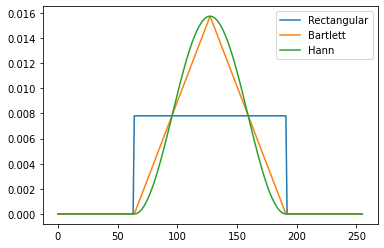

In [2]:
WINDOW_WIDTH = 128
FRAME_WIDTH = 256

square   = window_rectangular(WINDOW_WIDTH)
triangle = window_bartlett(WINDOW_WIDTH)
curve    = window_hann(WINDOW_WIDTH)

f1 = padwindow(square,FRAME_WIDTH)
f2 = padwindow(triangle,FRAME_WIDTH)
f3 = padwindow(curve,FRAME_WIDTH)

t_win = np.arange(256)
plt.plot(t_win,f1,t_win,f2,t_win,f3)
plt.legend(("Rectangular","Bartlett","Hann"));
plt.savefig("windows.png",dpi=350,facecolor='w');

So, with these three windows, we have differing levels of smoothness at the boundaries.

With the rectangular window, we actually have a discontinuity.

With the Bartlett window, we have a triangle shape that is continuous, but not differentiable.

Finally, with the Hann window, the first derivative is continuous.

If we plot the magnitudes of the fourier transforms, we can see that the smooth transitions provide a much sharper cutoff in frequency components, as the sinusoids have an easier time creating a good representation.

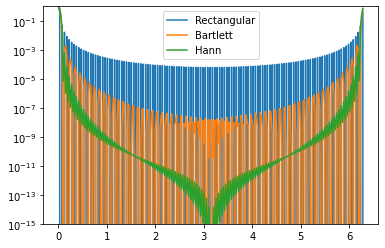

In [3]:
omega = np.linspace(0,2*np.pi, 256)
plt.plot(omega,np.abs(np.fft.fft(f1))**2,omega,np.abs(np.fft.fft(f2))**2,omega,np.abs(np.fft.fft(f3))**2)
plt.ylim((1e-15,1))
plt.yscale("log")
plt.legend(("Rectangular","Bartlett","Hann"));

While each filter goes to zero as some frequencies, the ripple is very large for the rectangular window in particular.

For the next part, we'll pad our window with more zeros.

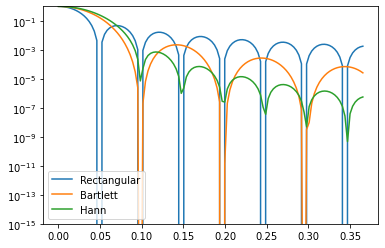

In [4]:
f1_l = padwindow(square,256*8)
f2_l = padwindow(triangle,256*8)
f3_l = padwindow(curve,256*8)

plt_range = range(0,120)

omega = np.linspace(0,2*np.pi, 256*8)
plt.plot(omega[plt_range],np.abs(np.fft.fft(f1_l)[plt_range])**2,omega[plt_range],np.abs(np.fft.fft(f2_l)[plt_range])**2,omega[plt_range],np.abs(np.fft.fft(f3_l)[plt_range])**2)
plt.ylim((1e-15,1))
plt.yscale("log")
plt.legend(("Rectangular","Bartlett","Hann"));

But while the ripple is the largest for the rectangular window, for the same amount of samples, the pass-band is the most narrow.

Similarly, the Bartlett window falls off a bit faster than the Hann window eventually.

# Benchmarking Convolution Code

The direct convolution should be $O(N^2)$, while the fft convolution should be approximately $O(N\log N)$

In [5]:
size_list = np.ceil(10 ** np.arange(1,4.1,0.1)).astype('int')
timings = np.zeros((2,len(size_list)))

for i in range(len(size_list)):
    a = np.random.randn(size_list[i])
    b = np.random.randn(size_list[i])

    setup = """
from __main__ import convolve_direct, convolve_fft
import numpy as np

a = np.random.randn(""" + str(size_list[i]) + """)
b = np.random.randn(""" + str(size_list[i]) + """)
    """

    timings[0, i] = min(timeit.repeat('convolve_direct(a,b)',repeat=100,number=1,setup=setup))
    timings[1, i] = min(timeit.repeat('convolve_fft(a,b)',repeat=100,number=1,setup=setup))


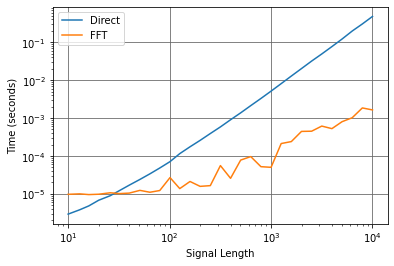

In [6]:
plt.plot(size_list,np.transpose(timings))
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.yscale("log")
plt.xscale("log")
plt.legend(("Direct","FFT"))
plt.xlabel("Signal Length")
plt.ylabel("Time (seconds)");
plt.savefig("benchmark.png",dpi=350,facecolor='w');

Now, let's look at what we're observing in the above plot.

After overcoming the smaller coefficients and initial overhead, the direct method take time of $O(N^2)$, while the frequency domain version should be approximately $O(N\log N)$.
The basic structure of the Fast Fourier Transform (FFT) algorithm generally follows the Cooley-Tukey FFT - an algorithm with an iconic "butterfly" structure which we will likely touch on later in the course.
It appears in chapter 3.9 of the text.
In short, the DFT can repeatedly be divided in 2, resulting in a logarithmic term instead of a squared term.
Despite our 100 trials, the plot does not look as clean as the direct form, likely because the more efficient FFT algorithms rely on having nice prime factorizations.

Additionally, the FFT method looks fairly flat at the beginning, which, while I (the TA) am not entirely certain of the reason, I suspect it may be because of the two part algorithm that is commonly used.

First, the transform function looks at the array and attempts to piece together different codelets (small optimized pieces of code) to form one cohesive fastest fourier transform for the given data, incorporating different FFT algorithms along the way.
In some libraries, this task can be done explicitely with a command titled something like `plan_fft`, and the plan can then be reused for similar data.

It then executes the chain of codelets in the second phase, ensuring no worse than $O(N\log N)$ growth, even for prime numbers.

If you tried doing the direct convolution without the numba compilation, it likely took at least a couple of orders of magnitude longer to execute, and you missed out on the neat fact that direct convolution is actually faster than using a fourier transform for very small sequences of data.

Finally, one note on the benchmarking method.
It is fairly common to use the minimum timing when benchmarking numerical code because other metrics can easily be skewed due to other processes sharing the CPU, garbage collection, or a number of automated systems outside of the function that sometimes temporarily take up time.

# Denoising A Signal

In this section, we will denoise a signal through a simple moving average.

We will begin by generating a noise vector.

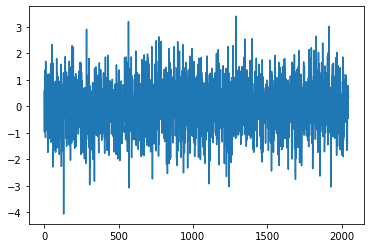

In [7]:
noise = np.random.randn(2048)
plt.plot(noise);

Now generate a signal.
In this notebook, we will just choose a few arbitary sine and cosine terms.

We are only looking at denoising in this notebook, so we will not add any distortion to the signal.

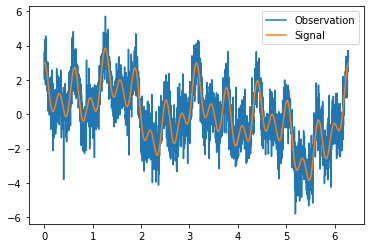

In [8]:
t = np.linspace(0,2*np.pi,2048)
x = np.sin(2*t) + np.cos(4*t) + np.cos(10*t) + np.sin(t) + np.cos(20*t)
y = noise + x
plt.plot(t,y, t, x)
plt.legend(("Observation","Signal"));

At this point, we'll use the functions that you wrote earlier to apply a moving average and attempt to denoise the signal.

/home/alvin/.virtualenv/ece551/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


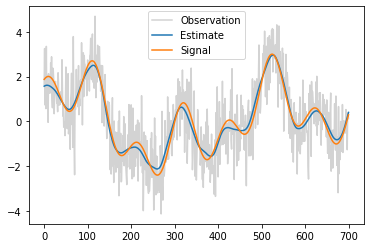

In [9]:
filter_length = 50

# Construct the filter
filter = np.fft.fftshift(padwindow(window_hann(filter_length),len(y)))

# Apply the filter
x_est = convolve_fft(filter,y)

# Plot a subset of the results
plotrange = range(500,1201)
plt.plot(y[plotrange], label="Observation",color='lightgrey')
plt.plot(x_est[plotrange], label="Estimate")
plt.plot(x[plotrange], label="Signal")
plt.legend();
plt.savefig("estimate.png",dpi=350,facecolor='w');

Now, for one fun final visual exploration, we've included your window and convolutions functions into an interactive cell. Play around with the slider and buttons to qualitatively see how the different filters behave.

The observation being filtered is a noisy chirp function, or a signal that increases in frequency over time.
It is essentially one form of function that fits the description in problem 1 of the homework because while the frequency components do not stay constant through the entire signal, if you were to decompose the signal as a whole, the bandwidth of the chirp would approximately be uniformly represented with different phase components.

In [10]:
chirp_gen_t = np.arange(0,10,0.01)
chirp = np.sin(2*np.pi * (chirp_gen_t**2 / 3))
observation = chirp + np.random.randn(len(chirp))

@interact 
def plot_filtered(Length = (3,40,1), Shape = ["Rectangular", "Bartlett", "Hann"], display_chirp = True, display_estimate = True):
    if Shape == "Rectangular":
        filter = np.fft.fftshift(padwindow(window_rectangular(Length),len(chirp)))
    elif Shape == "Bartlett":
        filter = np.fft.fftshift(padwindow(window_bartlett(Length),len(chirp)))
    else:
        filter = np.fft.fftshift(padwindow(window_hann(Length),len(chirp)))
    x_est = convolve_fft(filter,observation)
    if display_chirp:
        plt.plot(chirp,color='grey', linestyle='dashed',linewidth=1, label="Truth")
    if display_estimate:
        plt.plot(x_est,label="Estimate")
    plt.legend()


interactive(children=(IntSlider(value=21, description='Length', max=40, min=3), Dropdown(description='Shape', …